# Constants
Change these to fit your needs

In [75]:
# Are you developing locally or on google colab?
COLAB = True

# path kaggle will download to
HM_DATA_PATH = "/content/drive/MyDrive/dd2430/data/" if COLAB else "./data/"

# path tourch.save and .load will use
PTH_SAVE_PATH = "/content/drive/MyDrive/dd2430/pth/" if COLAB else "./pth/"

load_direct = True
if load_direct is True:
  HM_DATA_PATH, PTH_SAVE_PATH= '', '/content/'

# False if you have already downloaded once
DOWNLOAD_FROM_KAGGLE = True

# False if you have already created and saved a .pth file to PTH_SAVE_PATH
CREATE_NEW_DATASET = True

# train, test, val set size. Should sum to 1
SET_SIZES = {
    "train": 0.8,
    "test": 0.1,
    "val": 0.1,
}

# samples per class in uniform dataset
N_SAMPLES = 500

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Imports

In [2]:
import os
import random
import numpy as np
from tqdm import tqdm
if COLAB:
    from google.colab import files, drive
    !git clone https://github.com/Samin765/DD2430_Project.git.
    !mv -v /content/DD2430_Project/* /content/
import gdown

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import transformers

Cloning into 'DD2430_Project.git.'...
fatal: could not read Username for 'https://github.com': No such device or address
mv: cannot stat '/content/DD2430_Project/*': No such file or directory


In [73]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
if torch.backends.mps.is_available(): # For apple silicon
    device = 'mps'

print("Using device: ", device)

Using device:  cuda


# Download data

In [15]:
if DOWNLOAD_FROM_KAGGLE:
    !pip install kaggle
    files.upload()

    os.makedirs('/root/.kaggle', exist_ok=True)
    !cp kaggle.json /root/.kaggle/
    !chmod 600 /root/.kaggle/kaggle.json

    %cd HM_DATA_PATH

    !kaggle competitions download -c h-and-m-personalized-fashion-recommendations
    !unzip -q h-and-m-personalized-fashion-recommendations.zip

Saving kaggle.json to kaggle.json
[Errno 2] No such file or directory: 'HM_DATA_PATH'
/content
100% 28.7G/28.7G [04:22<00:00, 132MB/s]
100% 28.7G/28.7G [04:22<00:00, 117MB/s]


#Dataset

In [9]:
from datasets import HMDataset2, UniformHMDataset

## Create new dataset
This will create a new dataset and save it as a .pth to google drive.

In [76]:
if CREATE_NEW_DATASET:
    dataset = HMDataset2(
        articles_csv = HM_DATA_PATH + 'articles.csv',
        image_dir = HM_DATA_PATH + 'images',
        main_class = 'garment_group_name',
        model = transformers.CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device),
        processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    )
    # data per class
    n_samples = N_SAMPLES

    assert dataset.articles[dataset.main_class].value_counts().min()>n_samples, 'Can not make balanced set'

    # you can also set all to n_samples then set the ones you want to 0
    for exclude_subclass in ['Unknown', 'Special Offers', 'some other']:
        dataset.counts[exclude_subclass]=n_samples

    # Create uniform dataset
    image_emb, labels, images = dataset.get_n_of_each(n_samples)

    data_to_save = {
        'image_embedding': image_emb,
        'class_text': labels,
        'images': images,
    }
    os.makedirs(PTH_SAVE_PATH, exist_ok=True)
    torch.save(data_to_save, f'{PTH_SAVE_PATH}HM_data_{n_samples}.pth')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Max uniform size: 908


/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Image for article 174057028 not found. Takes next
Image for article 179208001 not found. Takes next
Image for article 212042043 not found. Takes next
Image for article 212042066 not found. Takes next
Image for article 212629004 not found. Takes next
Image for article 215324023 not found. Takes next
Image for article 216961011 not found. Takes next
Image for article 218354021 not found. Takes next
Image for article 241602023 not found. Takes next
Image for article 268305006 not found. Takes next
Image for article 272591001 not found. Takes next
Image for article 324963030 not found. Takes next
Image for article 348657006 not found. Takes next
Image for article 357792006 not found. Takes next
Image for article 364409037 not found. Takes next
Image for article 369423002 not found. Takes next
Image for article 369423004 not found. Takes next
Image for article 388916001 not found. Takes next
Image for article 395864048 not found. Takes next
Image for article 396690010 not found. Takes next


MessageError: Error: credential propagation was unsuccessful

In [96]:
def save_to_drive(data, n_samples):
    """Save the dataset you created to drive"""
    from google.colab import drive
    drive.mount('/content/drive')
    torch.save(data, f'/content/drive/My Drive/Skola/HM_data_{n_samples}.pth')
save_to_drive(data_to_save, N_SAMPLES)

Mounted at /content/drive


## Load dataset
If you already have the HM data and .pth saved in google drive, this is where the actual code/program begins.

Remember to change the constants at the top so you don't download and/or create a new dataset next time.

In [77]:
def load_from_private_drive():
    """If you have it locally"""
    #drive.mount('/content/drive')
    n_samples = N_SAMPLES
    file_to_load = f"HM_data_{n_samples}.pth"

    loaded_data = torch.load(f'{PTH_SAVE_PATH}{file_to_load}')

    image_emb = loaded_data['image_embedding']
    labels = loaded_data['class_text']
    images = loaded_data['images']

    #dataset = UniformHMDataset(image_emb, labels , images)
    return image_emb, images, labels

def load_from_project_drive(link='120f1W8QTNJ2d8rn6xLwNJ7m__r1nCyRp'):
    """Shared file in drive and insert link id"""
    import gdown
    output = 'data1.pth'
    gdown.download(f"https://drive.google.com/uc?id={link}", output, quiet=False)
    garment_group_name_500 =  torch.load(output)
    loaded_data = garment_group_name_500 # 500 per class
    image_emb = loaded_data['image_embedding']
    labels = loaded_data['class_text']
    images = loaded_data['images'] # good to have to see sclaling and transform..
    #dataset = UniformHMDataset(image_emb, labels , images)
    return image_emb, images, labels

project_drive = True # if you want to load from my drive
if project_drive:
  data = load_from_project_drive(link='15NxeYIZJ77mkpXGuVattIfvDfWBgF5JD')
else:
  data = load_from_private_drive()
image_emb0, images0, labels0 = data

<ipython-input-77-ed015b872959>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load(f'{PTH_SAVE_PATH}{file_to_load}')


##Split datasets

In [78]:
# dividing the data in equal parts to the three sets
combined = sorted(zip(labels0, image_emb0, images0), key=lambda x: x[0])
labels, image_emb, images = zip(*combined)

train_labels, train_image_emb, train_images = [], [], []
test_labels, test_image_emb, test_images = [], [], []
val_labels, val_image_emb, val_images = [], [], []

for i in range(0, len(combined) - 1, N_SAMPLES):
    labels_sub = labels[i : i + N_SAMPLES]
    image_emb_sub = image_emb[i : i + N_SAMPLES]
    images_sub = images[i : i + N_SAMPLES]

    s = lambda t: int(float(len(labels_sub)) * SET_SIZES[t])

    train_labels.extend(labels_sub[:s("train")])
    train_image_emb.extend(image_emb_sub[:s("train")])
    train_images.extend(images_sub[:s("train")])

    test_labels.extend(labels_sub[s("train"):s("train") + s("test")])
    test_image_emb.extend(image_emb_sub[s("train"):s("train") + s("test")])
    test_images.extend(images_sub[s("train"):s("train") + s("test")])

    val_labels.extend(labels_sub[s("train") + s("test"):])
    val_image_emb.extend(image_emb_sub[s("train") + s("test"):])
    val_images.extend(images_sub[s("train") + s("test"):])

# shuffle the data in each set
def shuffle_set(labels, image_emb, images):
    combined = list(zip(labels, image_emb, images))
    random.shuffle(combined)
    return zip(*combined)

train_labels, train_image_emb, train_images = shuffle_set(train_labels, train_image_emb, train_images)
test_labels, test_image_emb, test_images = shuffle_set(test_labels, test_image_emb, test_images)
val_labels, val_image_emb, val_images = shuffle_set(val_labels, val_image_emb, val_images)

# create the datasets
dataset = UniformHMDataset(labels, image_emb, images)
dataset_train = UniformHMDataset(train_image_emb, train_labels, train_images)
dataset_test = UniformHMDataset(test_image_emb, test_labels, test_images)
dataset_val = UniformHMDataset(val_image_emb, val_labels, val_images)

# checking
print(len(labels), len(dataset_train.labels), len(dataset_test.labels), len(dataset_val.labels))
print(dataset_train.labels)

# check class-balance of splits
from collections import Counter
for labels_ in [labels, dataset_train.labels, dataset_val.labels, dataset_test.labels]:
    print(Counter(labels_))


9500 7600 950 950
('Accessories', 'Shoes', 'Under-, Nightwear', 'Skirts', 'Jersey Fancy', 'Shoes', 'Outdoor', 'Dresses/Skirts girls', 'Jersey Fancy', 'Jersey Fancy', 'Dressed', 'Trousers Denim', 'Woven/Jersey/Knitted mix Baby', 'Socks and Tights', 'Jersey Fancy', 'Outdoor', 'Socks and Tights', 'Trousers Denim', 'Dresses/Skirts girls', 'Under-, Nightwear', 'Dresses/Skirts girls', 'Trousers Denim', 'Dresses/Skirts girls', 'Under-, Nightwear', 'Dressed', 'Jersey Basic', 'Accessories', 'Accessories', 'Under-, Nightwear', 'Shirts', 'Dresses/Skirts girls', 'Outdoor', 'Trousers Denim', 'Dresses Ladies', 'Jersey Fancy', 'Jersey Fancy', 'Jersey Fancy', 'Outdoor', 'Dresses Ladies', 'Outdoor', 'Woven/Jersey/Knitted mix Baby', 'Under-, Nightwear', 'Trousers Denim', 'Woven/Jersey/Knitted mix Baby', 'Blouses', 'Skirts', 'Shirts', 'Shirts', 'Outdoor', 'Dressed', 'Jersey Basic', 'Woven/Jersey/Knitted mix Baby', 'Accessories', 'Dresses/Skirts girls', 'Skirts', 'Trousers Denim', 'Dressed', 'Shirts', 'Je

#Coding

# Evaluate

In [82]:
model = transformers.CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
processor.feature_extractor.do_rescale = False # make sure image values: False=> [0-1] and True=> [0,255]

In [83]:
num_soft_prompts = 3
soft_prompts = nn.Parameter(torch.zeros(num_soft_prompts, model.text_projection.in_features), requires_grad=True)
#randn or zeros
optimizer = torch.optim.Adam([soft_prompts], lr=1e-3) # note that we here specify soft_prompts to tune

criterion = torch.nn.CrossEntropyLoss()

In [84]:
# functions for clip text and image embeddings, forward pass etc
# remember to import this again if you change something
import model_functions

In [85]:
# varius function that doesn't fit into model_functions or datasets
# for example displaying images
import utils

In [86]:
batch_size = 40
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

**Baseline model and untuned softprompt**


obs,compare so that the modified transformer gets same result if num_soft = 0 yes!

  0%|          | 0/190 [00:00<?, ?it/s]

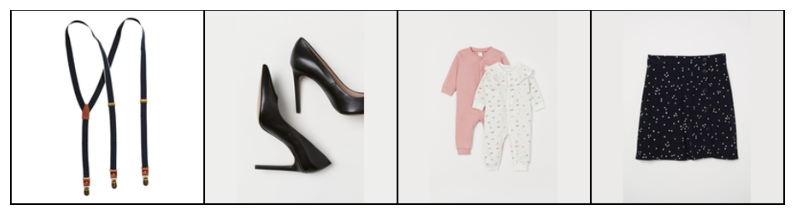

 21%|██        | 39/190 [00:01<00:03, 40.09it/s]

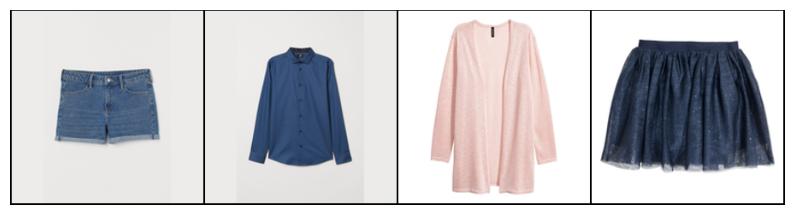

 42%|████▏     | 79/190 [00:02<00:02, 39.87it/s]

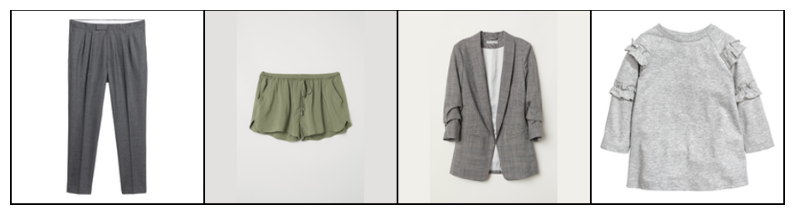

 63%|██████▎   | 119/190 [00:03<00:01, 43.26it/s]

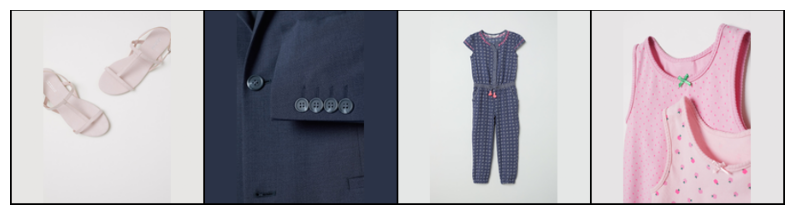

 84%|████████▎ | 159/190 [00:04<00:00, 42.73it/s]

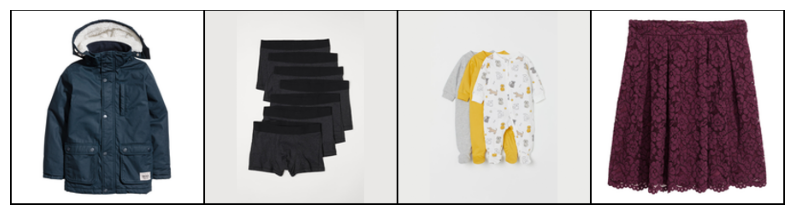

100%|██████████| 190/190 [00:05<00:00, 37.54it/s]


 Accuracy baseline 35.47368240356445 %
Accuracy Soft prompt untuned 36.0 %


In [87]:
show_image = True
all_predictions_baseline = []
all_predictions_soft_untuned = []
all_labels= []
with torch.no_grad():
    for batch_nr, (image_embeds, labels, images) in enumerate(tqdm(dataloader_train)):
        text = [' '+i for i in dataset_train.classes] # for prediction
        #text = ['An image of a '+i for i in labels] # for training
        #image_embeds, _ = get_image_emb(model, processor, return_normal(images, processor, 0, False)) #use or not
        # baseline
        text_embeds = model_functions.get_text_emb(model, processor, text)
        logits_per_image1, loss = model_functions.apply_clip(text_embeds, image_embeds, model)
        probs1 = logits_per_image1.softmax(dim=-1).cpu().numpy()
        # softprompts

        text_embeds = model_functions.get_text_emb_soft(model, processor, text, soft_prompts)

        logits_per_image2, loss = model_functions.apply_clip(text_embeds, image_embeds, model)
        probs2 = logits_per_image2.softmax(dim=-1).cpu().numpy()

        if show_image and batch_nr%40==0:
            images = utils.return_normal(images, processor, 4, True)
            #print(dataset.classes)
            #print(probs1.round(decimals=3))
            #print('Base, then soft')
            #print(probs2.round(decimals=3))

        predicted_class_base = logits_per_image1.argmax(dim=-1)
        predicted_class_soft_untuned = logits_per_image2.argmax(dim=-1)

        all_predictions_baseline.append(predicted_class_base)
        all_predictions_soft_untuned.append(predicted_class_soft_untuned)
        for lab in labels:
            all_labels.append(dataset_train.class_to_id[lab])


all_predictions_baseline=torch.cat(all_predictions_baseline).cpu()
all_predictions_soft_untuned=torch.cat(all_predictions_soft_untuned).cpu()

correct_base = all_predictions_baseline==torch.tensor(all_labels).cpu()
correct_soft_unt = all_predictions_soft_untuned==torch.tensor(all_labels).cpu()
print(f'\n Accuracy baseline {100*correct_base.sum()/correct_base.shape[0]} %')
print(f'Accuracy Soft prompt untuned {100*correct_soft_unt.sum()/correct_soft_unt.shape[0]} %')

**Finetuning**

Performance decreases if we add untuned soft prompts, now we finetune

In [88]:
show_image = True
#print(model)#https://github.com/search?q=repo%3Ahuggingface%2Ftransformers%20CLIPModel&type=code
model.train()
loss_list = []

epochs = 400 # max if nearly stop not trigger

param_es ={'pat': 10, 'curr_pat' :0, 'min_loss': np.inf, 'val_loss_list':[]}#early stop

for epoch in tqdm(range(epochs)):
    running_loss = 0.0
    for batch_nr, (image_embeds, labels, images) in enumerate(dataloader_train):
        optimizer.zero_grad()
        #images.to(model.device)
        #text = ['An image of a '+i for i in dataset.classes] # for prediction, can use what we want
        text = [''+i for i in labels] # for training, must use 1-1 map
        #image_embeds, _ = get_image_emb(model, processor, return_normal(images, processor, 0, False)) #SLOW
        text_embeds = model_functions.get_text_emb_soft(model, processor, text, soft_prompts)
        logits_per_image, loss = model_functions.apply_clip(text_embeds, image_embeds, model, train=True)
        loss.backward()
        optimizer.step()
        #print(soft_prompts.grad) to see that back prop works, is none otherwise
        running_loss +=loss.item()
    loss_list.append(running_loss/len(dataloader_train)/batch_size)
    val_loss = []
    with torch.no_grad():
        running_loss = 0.0
        for batch_nr, (image_embeds, labels, images) in enumerate(dataloader_val):# val loader
            text = [''+i for i in labels]
            text_embeds = model_functions.get_text_emb_soft(model, processor, text, soft_prompts)
            _, loss = model_functions.apply_clip(text_embeds, image_embeds, model, train=True)
            running_loss +=loss.item()
        param_es['val_loss_list'].append(running_loss/len(dataloader_val)/batch_size)
        if len(param_es['val_loss_list'])>2:# early stop
            if param_es['curr_pat'] ==0:
                if running_loss> param_es['val_loss_list'][-2]: # if val_loss increases
                    min_loss = running_loss
                    torch.save(soft_prompts, 'soft_prompts.pth')
                    param_es['curr_pat']+=1
            else:
                if running_loss> min_loss: # if val_loss increases
                    param_es['curr_pat']+=1
                    curr , pat = param_es['curr_pat'], param_es['pat']
                    print(f'Patience is {curr} / {pat}')
                    if param_es['curr_pat'] >=param_es['pat']:
                        break
                else:
                    param_es['min_loss'] = np.inf
                    param_es['curr_pat'] = 0






  1%|          | 4/400 [00:27<46:03,  6.98s/it]

Patiense is 2 / 10


  1%|▏         | 5/400 [00:34<45:36,  6.93s/it]

Patiense is 3 / 10


 16%|█▋        | 66/400 [07:40<38:55,  6.99s/it]

Patiense is 2 / 10


 17%|█▋        | 67/400 [07:47<38:38,  6.96s/it]

Patiense is 3 / 10


 17%|█▋        | 68/400 [07:54<38:05,  6.88s/it]

Patiense is 4 / 10


 17%|█▋        | 69/400 [08:01<38:07,  6.91s/it]

Patiense is 5 / 10


 18%|█▊        | 70/400 [08:07<38:05,  6.93s/it]

Patiense is 6 / 10


 18%|█▊        | 71/400 [08:14<37:52,  6.91s/it]

Patiense is 7 / 10


 18%|█▊        | 72/400 [08:21<37:46,  6.91s/it]

Patiense is 8 / 10


 18%|█▊        | 73/400 [08:29<38:26,  7.05s/it]

Patiense is 9 / 10


 18%|█▊        | 73/400 [08:36<38:32,  7.07s/it]

Patiense is 10 / 10


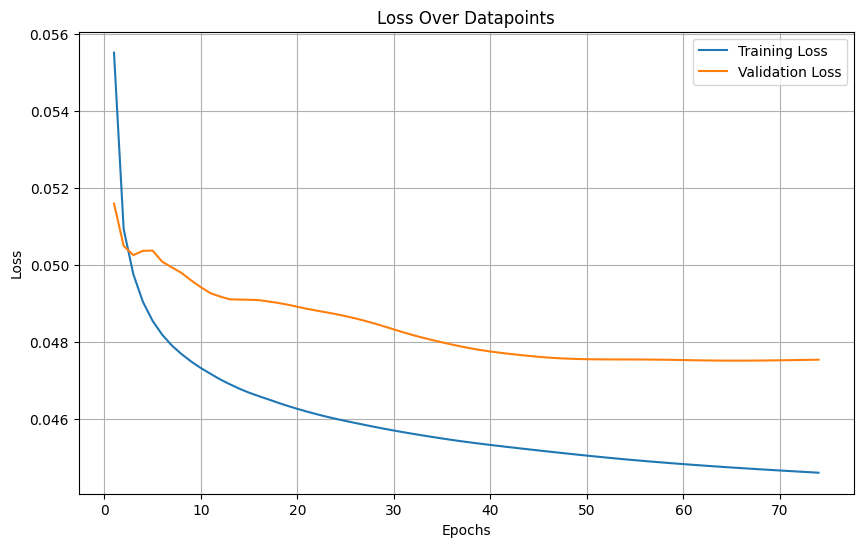

In [93]:
plt.figure(figsize=(10, 6))
plt.plot(list(range(1, len(loss_list)+1)), loss_list, label='Training Loss')
plt.plot(list(range(1, len(param_es['val_loss_list'])+1)), param_es['val_loss_list'], label='Validation Loss')
# Adding labels and title
plt.title('Loss Over Datapoints')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Evaluate performance**

In [94]:
all_labels= []
all_predictions_soft = []
soft_prompts = torch.load('soft_prompts.pth') # best values found
with torch.no_grad():
    for batch_nr, (image_embeds, labels, images) in enumerate(tqdm(dataloader_test)):
        text = [''+i for i in dataset_test.classes] # for eval
        #image_embeds, _ = get_image_emb(model, processor, return_normal(images, processor, 0, False)) #use or not
        #text_embeds = get_text_emb_soft(model, processor, text, soft_prompts)
        text_embeds = model_functions.get_text_emb_soft(model, processor, text, soft_prompts)
        logits_per_image2, loss = model_functions.apply_clip(text_embeds, image_embeds, model)
        predicted_class_soft = logits_per_image2.argmax(dim=-1)
        all_predictions_soft.append(predicted_class_soft)
        for lab in labels:
            all_labels.append(dataset_test.class_to_id[lab])
all_predictions_soft=torch.cat(all_predictions_soft).cpu()
correct_soft = all_predictions_soft==torch.tensor(all_labels).cpu()

<ipython-input-94-b23241485513>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  soft_prompts = torch.load('soft_prompts.pth') # best values found
100%|██████████| 24/24 [00


Of 18 classes random is 0.05555555555555555%
Accuracy baseline 35.47368240356445 %
Accuracy Soft prompt untuned 36.0 %
Accuracy Soft prompt 68.63157653808594 %
              precision    recall  f1-score   support

           0       0.68      0.53      0.60        64
           1       0.94      0.87      0.90        54
           2       0.56      0.61      0.58        46
           3       0.72      0.84      0.77        43
           4       0.70      0.81      0.75        43
           5       0.98      0.96      0.97        51
           6       0.88      0.79      0.83        56
           7       0.98      0.88      0.92        56
           8       0.48      0.51      0.49        47
           9       0.48      0.60      0.53        40
          10       0.46      0.59      0.52        39
          11       0.90      0.64      0.75        70
          12       0.36      0.49      0.41        37
          13       0.70      0.71      0.71        49
          14       0.58     

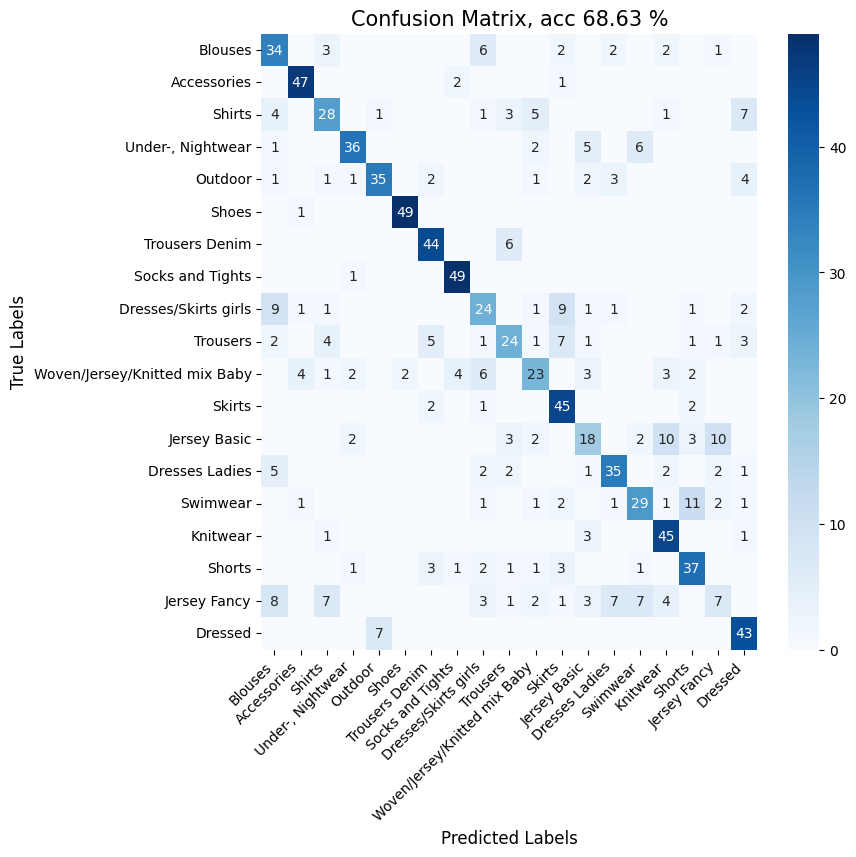

In [95]:
print(f'\nOf {max(all_labels)} classes random is {1/max(all_labels)}%')
print(f'Accuracy baseline {100*correct_base.sum()/correct_base.shape[0]} %')
print(f'Accuracy Soft prompt untuned {100*correct_soft_unt.sum()/correct_soft_unt.shape[0]} %')
acc_soft = 100*correct_soft.sum()/correct_soft.shape[0]
print(f'Accuracy Soft prompt {acc_soft} %')

from sklearn.metrics import classification_report
print(classification_report(all_predictions_soft, all_labels))
import numpy as np

import seaborn as sns
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(8, 8))

cm = confusion_matrix(all_labels, all_predictions_soft)
categories = list(dataset_test.class_to_id.keys())
annot = np.where(cm != 0, cm, '')
sns.heatmap(cm, annot= annot, fmt="", cmap="Blues", cbar=True,xticklabels=categories, yticklabels=categories)
# Add labels

plt.xticks(rotation=45, ha="right", fontsize=10)
plt.title(f"Confusion Matrix, acc {acc_soft:.2f} %", fontsize=15)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
# Show the plot
plt.show()
